**Install dependencies:** In case this notebook is not running [Carto-Lab Docker](https://cartolab.theplink.org/), the cell below aims to install the needed packages for this notebook. If packages are already available, they will be ignored.

In [1]:
import sys
pyexec = sys.executable
print(f"Current Kernel {pyexec}")
!../py/modules/pkginstall.sh "{pyexec}" geopandas matplotlib

Current Kernel /opt/conda/envs/worker_env/bin/python3.13
geopandas already installed (version 1.0.1).
matplotlib already installed (version 3.10.1).


# Clipping Data


```{admonition} Summary
:class: hint


```

Clipping is a process used to extract specific parts of data based on a predefined dataset that represents the area of interest. The `geopandas` and `matplotlib` packages are used for this process.

In [2]:
import geopandas as gp
import matplotlib.pyplot as plt
from pathlib import Path

INPUT = Path.cwd().parents[0] / "00_data"
OUTPUT = Path.cwd().parents[0] / "out"
OUTPUT.mkdir(exist_ok=True)

gdb_path = INPUT / "Biotopwerte_Dresden_2018.gdb"

## Clipping Based on Zone (Dataset)

The areas of interest in this chapter are districts in Dresden. 

`````{admonition} Dresden Portal!
:class: attention, dropdown
The districts are extracted from the [Portal of Dresden](https://opendata.dresden.de/informationsportal/?open=1&result=493101D03C794E9C99CD8B2BAC194FEC#app/mainpage////).
`````

For retrieving the data, from the Geojson section of the portal, based on the interested format, the URL is chosen.

In [3]:
geojson_url = "https://kommisdd.dresden.de/net4/public/ogcapi/collections/L137/items"

Then the `requests` library is imported and a request is sent to the portal to extract the data.

In [4]:
import requests

response = requests.get(geojson_url)

Then if the request is successful (code 200), it will load and plot the data.

   id                        bez  \
0  02        Pirnaische Vorstadt   
1  53               Striesen-Süd   
2  97  Gorbitz-Nord/Neu-Omsewitz   
3  22                    Mickten   
4  95                Gorbitz-Süd   

                                         bez_lang  flaeche_km2   sst sst_klar  \
0                             Pirnaische Vorstadt       0.9281  None     None   
1             Striesen-Süd mit Johannstadt-Südost       1.3276  None     None   
2                       Gorbitz-Nord/Neu-Omsewitz       0.8557  None     None   
3  Mickten mit Trachau-Süd, Übigau und Kaditz-Süd       4.2435  None     None   
4                                     Gorbitz-Süd       1.2604  None     None   

  historie                 aend  \
0      akt  20.03.2025 00:00:00   
1      akt  20.03.2025 00:00:00   
2      akt  20.03.2025 00:00:00   
3      akt  20.03.2025 00:00:00   
4      akt  20.03.2025 00:00:00   

                                            geometry  
0  POLYGON ((13.75017 51.04619

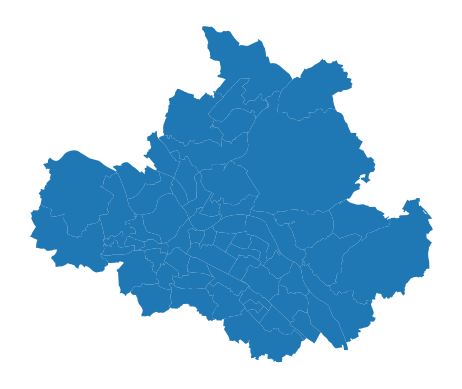

In [5]:
if response.status_code == 200:
    gdf = gp.read_file(geojson_url)
    print(gdf.head())
    ax=gdf.plot()
    ax.set_axis_off()
else:
    print("Error:", response.text)

`````{admonition} Selecting the area of interest!
:class: danger, dropdown
To select the area of interest, the methods mentioned in the [Selecting and Filtering Chapter](https://stag.training.fdz.ioer.info/notebooks/303_selecting_and_filtering.html#selecting-and-filtering-data) could be used, but also it is possible to add the labels to maps and select based on labels.
`````

To add the labels, first, the position of the labels should be defined.

The centroid of the polygons would be the position of the labels and is generated using the `geometry.centroid` method and stored in a new column.

In [6]:
gdf["centroid"] = gdf.geometry.centroid 

/tmp/ipykernel_2419/1565410799.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.geometry.centroid


For adding the labels the `text` function is used.

The coordinates of the centroid are the position of the labels and the label text is defined with `str`.
In the following example, the IDs of the districts are used.

`````{admonition} Labels in the map!
:class: note, dropdown
To customize the labels more, check [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html).
`````

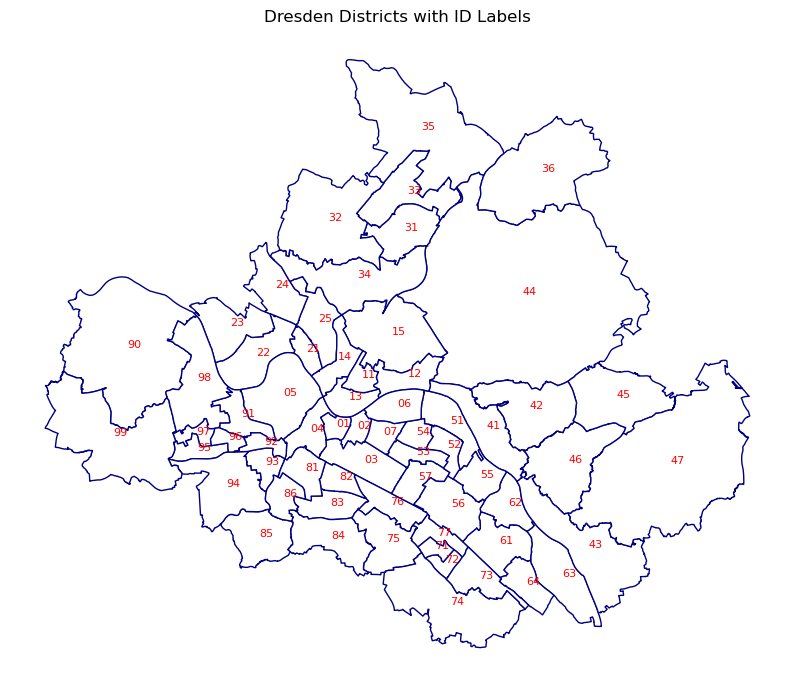

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='white', edgecolor='navy')
ax.set_axis_off()

for idx, row in gdf.iterrows():
    plt.text(row.centroid.x, row.centroid.y, str(row['id']),
             fontsize=8, 
             color='red')

plt.title("Dresden Districts with ID Labels")
plt.show()


Now using the labels the interested area is selected.

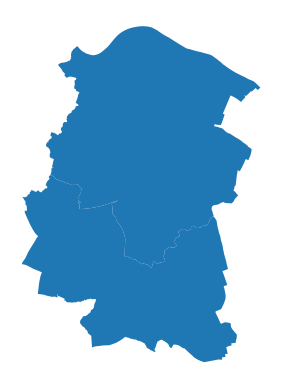

In [8]:
clipping_dataset= gdf[gdf['id'].isin(['90','99'])]
ax=clipping_dataset.plot()
ax.set_axis_off()

The path to the original dataset and the clipping dataset, based on which the original dataset should be clipped, will be defined.

In [9]:
original_dataset = gp.read_file(gdb_path, layer="Biotopwerte_Dresden_2018")

/opt/conda/envs/worker_env/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


The coordinate system of the datasets is checked. If the coordinate systems do not match, the clipping process will not proceed.

In [10]:
original_dataset.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Croatia; Denmark - offshore and offshore; Germany - onshore and offshore; Italy - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 34.79, 18.01, 84.01)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
clipping_dataset.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

If the coordinate systems are not the same, they are transformed to match.

In [12]:
clipping_dataset = clipping_dataset.to_crs('EPSG:25833')

The dataset is then clipped by defining the original dataset and the clipping dataset using the `clip` function in the `geopandas` package.

In [13]:
clipped_dataset = gp.clip(original_dataset, clipping_dataset)

And the result of the clip operation will be printed out.

In [14]:
clipped_dataset.head(3)

CLC_st1  Biotpkt2018  Shape_Length    Shape_Area  \
261       122     5.271487   1765.048621   6984.236836   
5928      322    18.055116    204.848619    582.329680   
13027     142     7.000000    481.434416  11886.564349   

                                                geometry  
261    POLYGON ((404092.96 5654379.53, 404098.204 565...  
5928   POLYGON ((404867.05 5654106.356, 404862.483 56...  
13027  POLYGON ((405339.13 5654136.481, 405172.058 56...

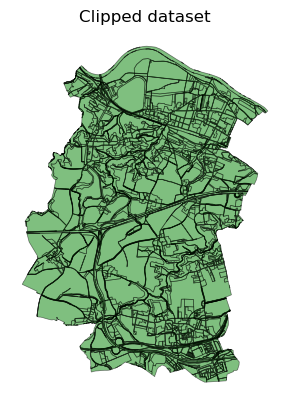

In [15]:
ax = clipped_dataset.plot(color="green", linewidth=0.5, alpha=0.5, edgecolor="black")
ax.set_title("Clipped dataset")
ax.set_axis_off()

The result can be saved in various formats. All you need to do is define the output path and export based on the format you are interested in.

- **Shapefile Format**

In [16]:
output_shp = OUTPUT / "clipped.shp"
clipped_dataset.to_file(output_shp)

/tmp/ipykernel_2419/1343647297.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_dataset.to_file(output_shp)
/opt/conda/envs/worker_env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Biotpkt2018' to 'Biotpkt201'
  ogr_write(
/opt/conda/envs/worker_env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Shape_Length' to 'Shape_Leng'
  ogr_write(


- **GeoPackage Format** 

In [17]:
output_gdb = OUTPUT / "clipped.gpkg"
clipped_dataset.to_file(
    output_gdb,
    layer="clipped_dataset",
    driver="GPKG")

- **CSV Format** or **WKT Format**

```{admonition} **Geometry as WKT**
:class: caution, dropdown
Our data is already in WKT format. If the dataset doesn't have a geometry column in Well Known Text format, it should be converted first, as mentioned in the next steps. You will see in the final CSV file saved below that the two columns "geometry" and "geometry_wkt" match.
```

Have a look at the `geometry` column, which commonly exists for GeoDataFrames

In [18]:
clipped_dataset.geometry

261      POLYGON ((404092.96 5654379.53, 404098.204 565...
5928     POLYGON ((404867.05 5654106.356, 404862.483 56...
13027    POLYGON ((405339.13 5654136.481, 405172.058 56...
15142    POLYGON ((405337.399 5654208.987, 405336.192 5...
3572     POLYGON ((405336.192 5654214.027, 405335.975 5...
                               ...                        
24741    POLYGON ((403517.379 5661823.326, 403517.089 5...
11147    POLYGON ((403506.01 5661746.878, 403512.79 566...
33830    MULTIPOLYGON (((403834.523 5661937.043, 403787...
33829    POLYGON ((403103.13 5662019.63, 403184.07 5662...
33831    POLYGON ((403506.092 5662087.066, 403484.425 5...
Name: geometry, Length: 2923, dtype: geometry

First, ensure that the `geometry` column contains valid geometries. We need to check if all values in `clipped_dataset["geometry"]` are actual `shapely.geometry` objects.

Check if there are any missing geometries (`.isna()`).

In [19]:
print(clipped_dataset["geometry"].isna().sum())  # Count missing values

0


Check the types of geometries.

In [20]:
print(clipped_dataset.geom_type.value_counts())

Polygon         2833
MultiPolygon      90
Name: count, dtype: int64


Explicitly store WKT geometries in a new column. This uses the [apply function with a lambda expression](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) to convert each geometry in the column to a string format.

In [21]:
from shapely.geometry import Polygon, MultiPolygon

clipped_dataset["geometry_wkt"] = clipped_dataset["geometry"].apply(
    lambda geom: geom.wkt if isinstance(geom, (Polygon, MultiPolygon)) else None
)

The output path is defined, and the data is saved as a CSV file. If the index column, which represents unique values for rows, is not needed, the `index` parameter can be set to `False`.

```{admonition} **Parameters for CSV file**
To learn how to customize your CSV data, visit the pandas [DataFrame to CSV page](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html).
```

In [22]:
csv_path = OUTPUT / "clipped_dataset.csv"
clipped_dataset.to_csv(csv_path, index=True)

## Clipping Based on Bounding Box

To show a specific area of the dataset, the data can be clipped to a defined bounding box and then visualized.

For this reason, the required part of the dataset is selected and the bounding box is extracted for this rows.

```{admonition} Bounding Box
:class: attention 
The bounding box extraction explained more in [Creating Maps Chapter](https://stag.training.fdz.ioer.info/notebooks/306_mapping.html#plot-features-within-bounding-box).
```

In [23]:
required_part= original_dataset[80:120].total_bounds

Then the dataset clipped for plotting:

In [24]:
gdf_clipped = gp.clip(original_dataset, required_part)

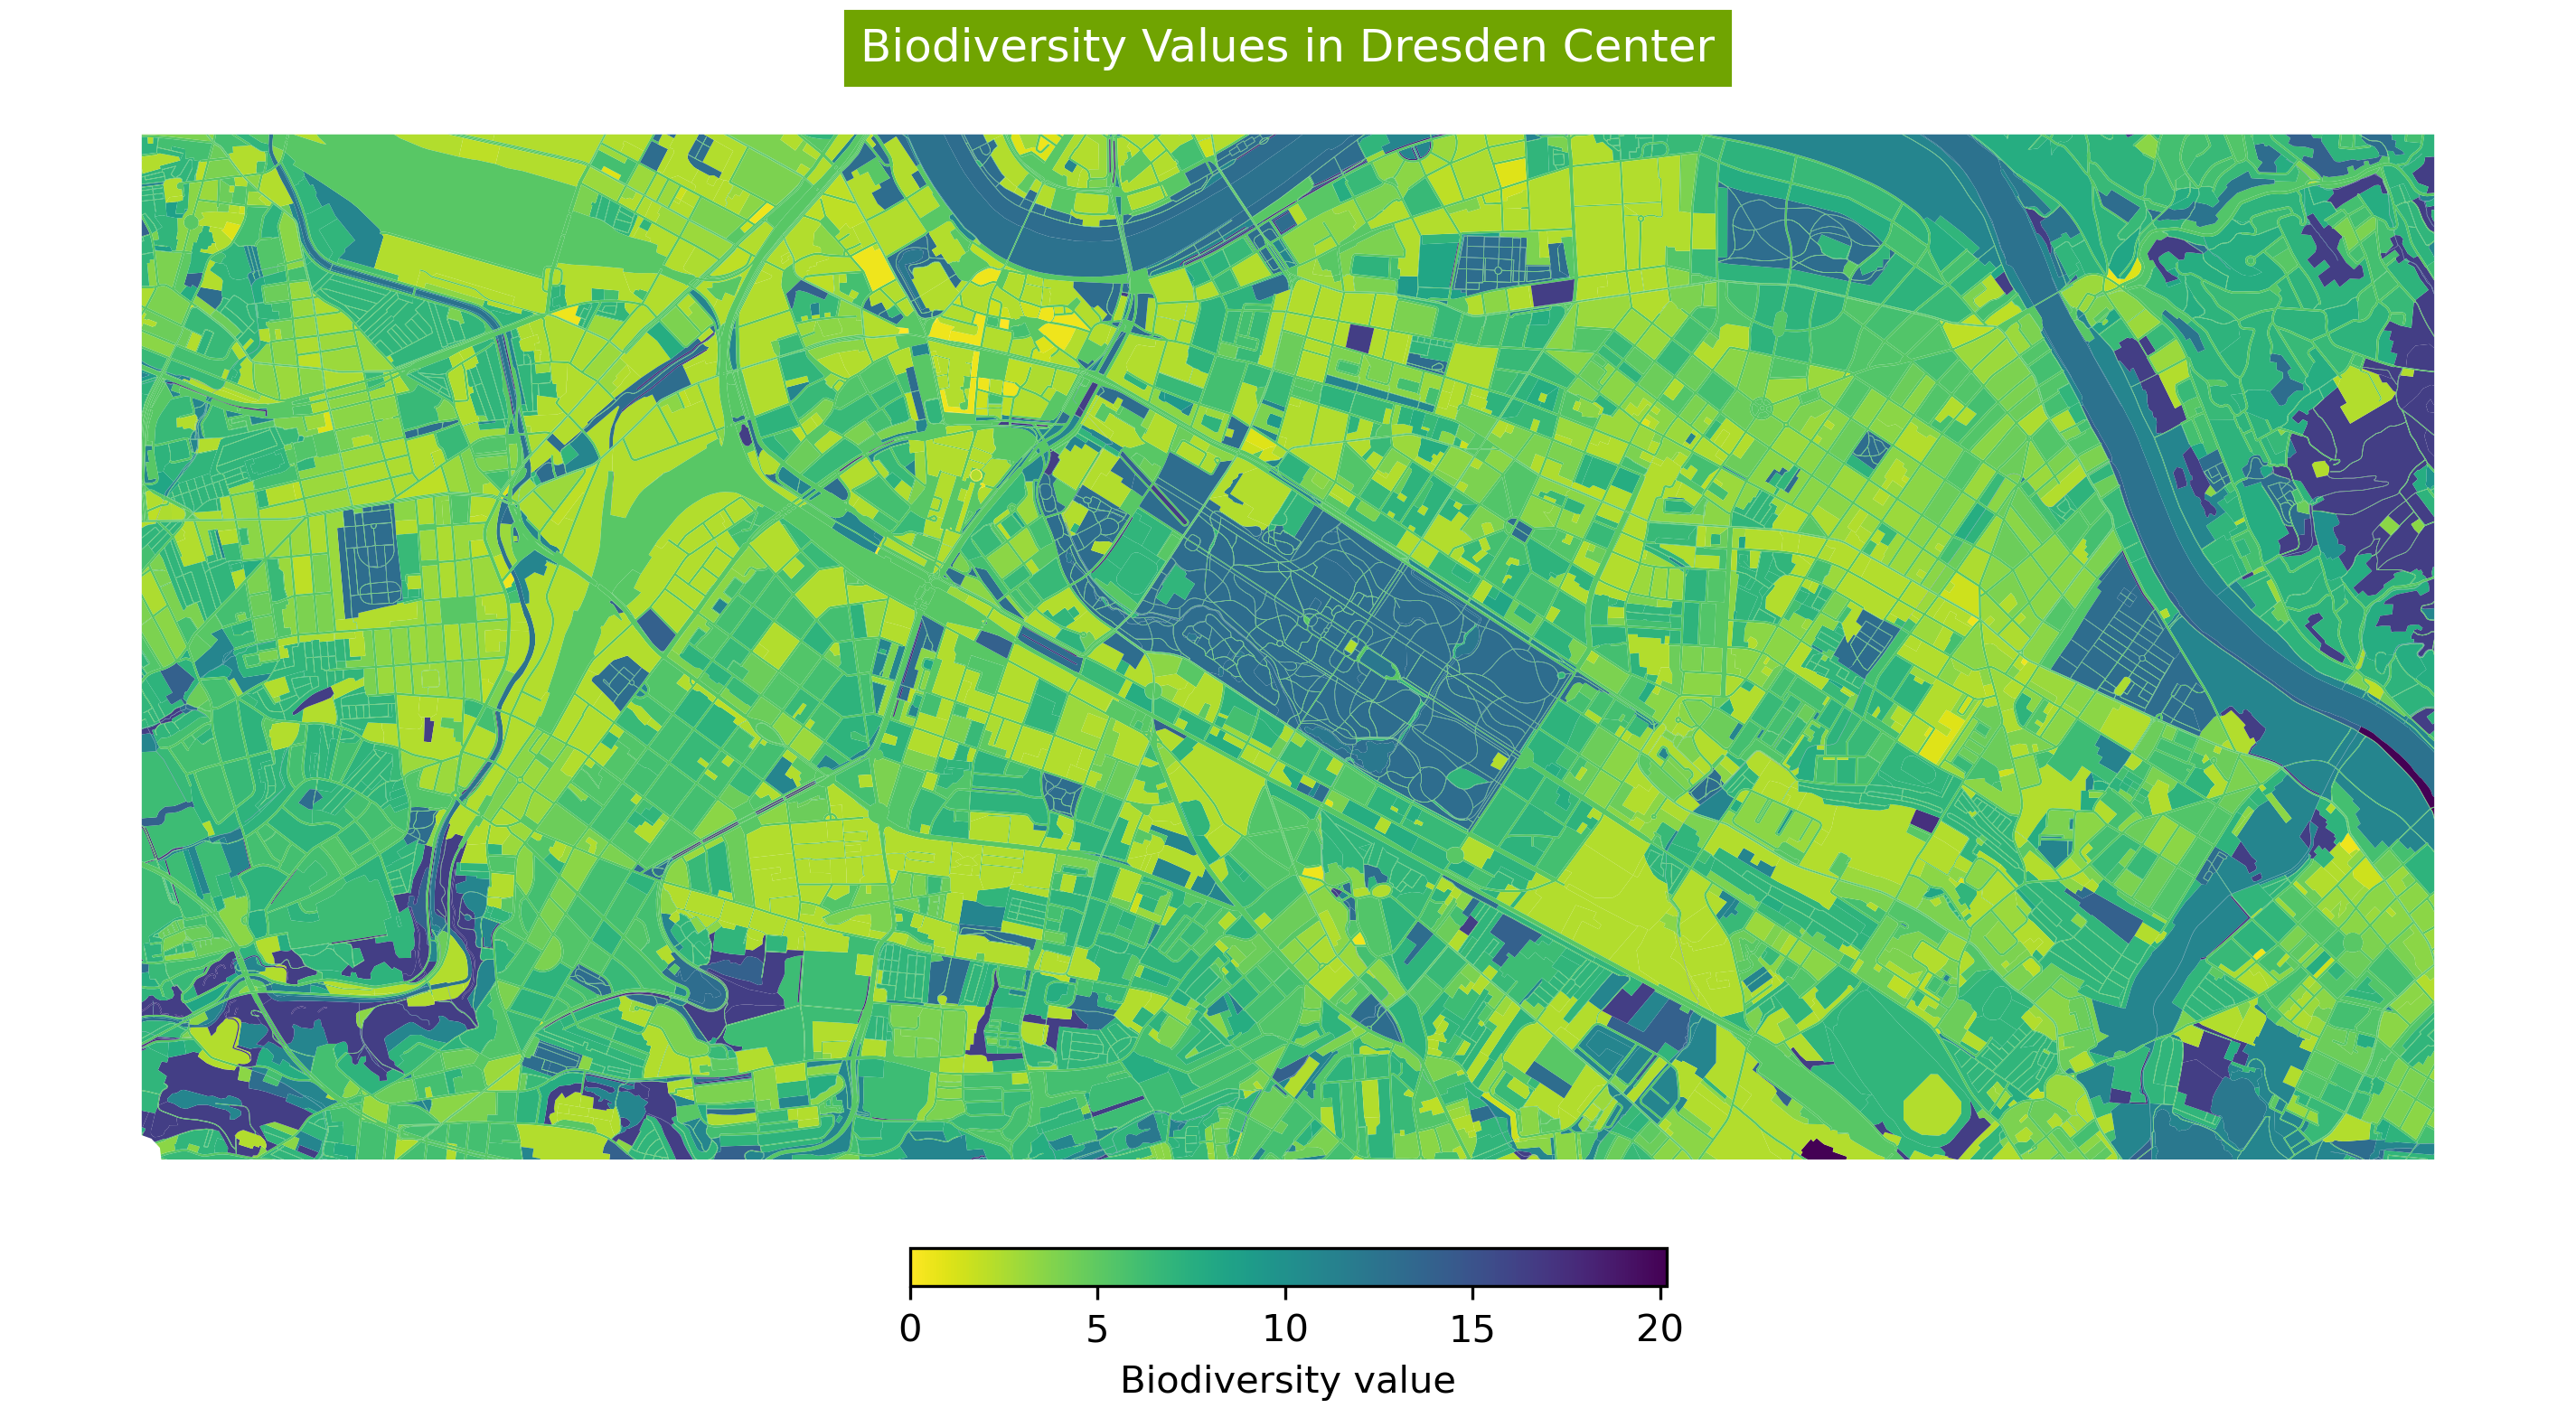

In [25]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(12, 18), dpi=300)

ax = gdf_clipped.plot(
    ax=ax,
    column='Biotpkt2018', 
    cmap='viridis_r',
    legend=True,
    legend_kwds={
        "label": "Biodiversity value", "orientation": "horizontal",
        "shrink": 0.3, "pad": 0.01})

ax.set_title('Biodiversity Values in Dresden Center',
             backgroundcolor='#70A401',
             color='white')
ax.set_axis_off()